In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from scipy.stats import binom
from tqdm import tqdm

In [8]:
# beta = 1
# B = 0
# kappa = 2
# The states are marked mu(x0, k), where x0 is the spin of the root node and k is the number of
# leaves that are spin-up

def eta(kappa=2):
    multiplicity = np.fromfunction(lambda _, k: scipy.special.comb(kappa, k), (2, kappa+1))
    eta = multiplicity / (2 ** (kappa+1))
    return eta

def Hamiltonian(x0, k, beta=1, B=0, kappa=2):
    x0 = 2 * x0 - 1
    return beta / 2 * x0 * (2 * k - kappa) + B * x0

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)

def edge_distribution(p, kappa=2):
    counts = np.vstack((kappa - np.arange(kappa+1),
                        np.arange(kappa+1)))
    return p @ counts.T / kappa

def objective_function(mu, beta=1, B=0, kappa=2):
    hamiltonian = np.fromfunction(lambda x0, k: Hamiltonian(x0, k, beta, B, kappa), (2, kappa+1))
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta(kappa=kappa))
    pi_mu = edge_distribution(mu, kappa=kappa)
    pi_eta = edge_distribution(eta(kappa=kappa), kappa=kappa)
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + kappa / 2 * marg_rel_entr
    
def norm_constraint(mu):
    return np.sum(mu) - 1

# def norm_constraint_grad(mu):
#     return mu

def admissibility_constraint(mu):
    pi_mu = edge_distribution(mu)
    return pi_mu[0, 1] - pi_mu[1, 0]

# def admissibility_constraint_grad(mu):
#     grad_01 = np.concatenate([kappa - np.arange(kappa+1),
#                               np.zeros((1, kappa+1))], axis=0)
#     grad_10 = np.concatenate([np.zeros((1, kappa+1)),
#                               np.arange(kappa+1)], axis=0)
#     return grad_01 - grad_10

print(f'{eta()=}')
print(f'{edge_distribution(eta())=}')

eta()=array([[0.125, 0.25 , 0.125],
       [0.125, 0.25 , 0.125]])
edge_distribution(eta())=array([[0.25, 0.25],
       [0.25, 0.25]])


In [13]:
def optimize(beta, B, kappa, mu0=None, verbose=False, ftol=1e-9, constr_tol=1e-10):
    if mu0 is None:
        p_x0 = 1/2
        p_up = np.random.uniform(0, 1)
        p_xv0 = binom.pmf(np.arange(kappa+1), kappa, p_up)
        p_xv1 = binom.pmf(np.arange(kappa+1), kappa, 1 - p_up)
        mu0 = np.vstack([p_xv0, p_xv1]) * np.array([[p_x0], [1 - p_x0]])
    
    if verbose:
        print(f'{beta=}, {B=}, {kappa=}\n{mu0=}')
    
    bounds = Bounds(np.zeros_like(mu0.flatten()), np.ones_like(mu0.flatten()))

    norm_constraint = LinearConstraint(np.ones_like(mu0.flatten()), 1, 1)
    admissibility_linear = np.hstack((-np.arange(kappa+1), kappa - np.arange(kappa+1))) / kappa
    admissibility_constraint = LinearConstraint(admissibility_linear, lb=0, ub=0)
    
    res = minimize(lambda mu: -objective_function(mu.reshape(2, kappa+1), beta=beta, B=B, kappa=kappa),
                   x0=mu0.flatten(), method='SLSQP', 
                   constraints=[norm_constraint, admissibility_constraint],
                   bounds=bounds,
                   options={'ftol': ftol, 'disp': verbose})
    
    mu = res.x.reshape(2, kappa+1)
    
    if verbose:
        print(f'{objective_function(mu, beta, B, kappa)=}\n')
        print(f'{mu=}\n\n{np.sum(mu)=}\n\n{edge_distribution(mu, kappa)=}')
    
    return mu

In [11]:
mu = optimize(beta=1, B=0, kappa=4, verbose=True)

beta=1, B=0, kappa=4
mu0=array([[0.0074579 , 0.05553048, 0.155052  , 0.19241583, 0.08954379],
       [0.08954379, 0.19241583, 0.155052  , 0.05553048, 0.0074579 ]])
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3072009765691064
            Iterations: 50
            Function evaluations: 622
            Gradient evaluations: 50
objective_function(mu, beta, B, kappa)=1.3072009765691064

mu=array([[0.00000000e+00, 8.63522739e-09, 7.51779624e-07, 2.59176963e-05,
        3.34959341e-04],
       [9.06984004e-18, 0.00000000e+00, 7.35781139e-07, 1.41763109e-03,
        9.98219996e-01]])

np.sum(mu)=1.0

edge_distribution(mu, kappa)=array([[6.86179032e-06, 3.54775662e-04],
       [3.54775662e-04, 9.99283587e-01]])


/Users/yizhonghu/anaconda3/envs/smrg/lib/python3.10/site-packages/scipy/optimize/_constraints.py:459: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


### P(X0, X1)

In [189]:
mu = optimize(beta=5, B=0.1, kappa=2, ftol=1e-10)

pi_mu = edge_distribution(mu)
print(f'{pi_mu=}')
p_x0 = np.sum(pi_mu, axis=1)
p_x1 = np.sum(pi_mu, axis=0)
print(f'{p_x0=}', f'{p_x1=}')
print(f'{np.outer(p_x0, p_x1)=}')

pi_mu=array([[6.42514153e-08, 8.05578642e-09],
       [8.05600510e-09, 9.99999920e-01]])
p_x0=array([7.23072017e-08, 9.99999928e-01]) p_x1=array([7.23074204e-08, 9.99999928e-01])
np.outer(p_x0, p_x1)=array([[5.22834723e-15, 7.23071965e-08],
       [7.23074152e-08, 9.99999855e-01]])


/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


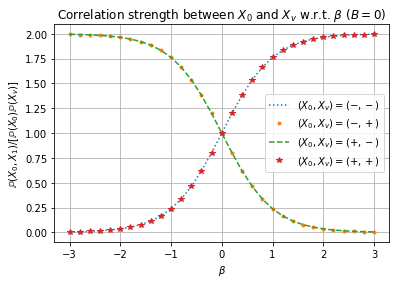

In [232]:
betas = np.linspace(-3, 3, 31)
probabilities = []

for beta in betas:
    mu = optimize(beta=beta, B=0, kappa=2, ftol=1e-10)
    pi_mu = edge_distribution(mu)
    p_x0 = np.sum(pi_mu, axis=1)
    p_x1 = np.sum(pi_mu, axis=0)
    indep_dist = np.outer(p_x0, p_x1)
    probabilities.append(pi_mu / indep_dist)
    
probabilities = np.array(probabilities)

plt.plot(betas, probabilities[:, 0, 0], ':', label='$(X_0, X_v)=(-, -)$')
plt.plot(betas, probabilities[:, 0, 1], '.', label='$(X_0, X_v)=(-, +)$')
plt.plot(betas, probabilities[:, 1, 0], '--', label='$(X_0, X_v)=(+, -)$')
plt.plot(betas, probabilities[:, 1, 1], '*', label='$(X_0, X_v)=(+, +)$')
plt.legend()
plt.title('Correlation strength between $X_0$ and $X_v$ w.r.t. $\\beta$ ($B=0$)')
plt.xlabel('$\\beta$')
plt.ylabel('$\\mathbb{P}(X_0, X_1) / [\\mathbb{P}(X_0)\\mathbb{P}(X_v)]$')
plt.grid(True)
plt.savefig('../img/ising_x0_xv.png')

[[ 1. -1.]
 [-1.  1.]]
[-0.9923801666781719, -0.9886531648567929, -0.983119382573301, -0.9749213031415295, -0.9628183828678059, -0.9450416750842694, -0.9191263892513659, -0.8817749771611014, -0.8288286515074272, -0.7556224269277634, -0.6580431463039953, -0.5347702998106019, -0.39069486185689656, -0.23983385383566022, -0.10343201839475774, -5.919413046094008e-07, 0.06566525583982986, 0.10170883400195564, 0.11968839886269995, 0.1281713339966473, 0.13208354981835674, 0.13395871337345666, 0.13462569236730304, 0.13433896505411747, 0.13528428784162155, 0.13556766471559895, 0.1347256543368597, 0.13329872774519905, 0.13221755413334016, 0.137332867598262, 0.11958233645906066]
[-0.9950300593764294, -0.9925952718966711, -0.9889736852407262, -0.9835943492930924, -0.9756226091648514, -0.9638503235841411, -0.9465460387236841, -0.921290941153878, -0.8848161141869499, -0.8328978687632984, -0.7605623688037627, -0.6626962007533855, -0.5354331865834698, -0.37824530770829673, -0.19605804001553562, -4.3739

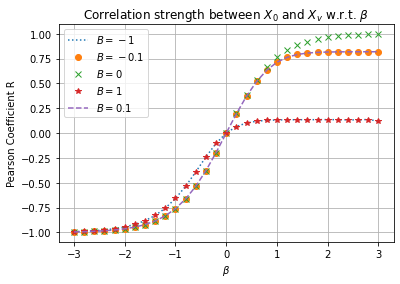

In [231]:
betas = np.linspace(-3, 3, 31)
Bs = [-1, -0.1, 0, 1, .1]

x_times_y = np.fromfunction(lambda x, y: (2*x-1) * (2*y-1), (2, 2))
xs = np.fromfunction(lambda x, y: 2*x-1, (2, 2))
ys = np.fromfunction(lambda x, y: 2*y-1, (2, 2))
print(x_times_y)

for B, m in zip(Bs, [':', 'o', 'x', '*', '--']):
    pearson_coeff = []

    for beta in betas:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)
        pi_mu = edge_distribution(mu)
        p_x0 = np.sum(pi_mu, axis=1)
        p_x1 = np.sum(pi_mu, axis=0)
        indep_dist = np.outer(p_x0, p_x1)
        
        cov = np.sum(pi_mu * x_times_y) - np.sum(pi_mu * xs) * np.sum(pi_mu * ys)
        var0 = np.sum(p_x0 * np.array([-1, 1])**2) - np.sum(p_x0 * np.array([-1, 1]))**2
        var1 = np.sum(p_x1 * np.array([-1, 1])**2) - np.sum(p_x1 * np.array([-1, 1]))**2
        pearson_coeff.append(cov / np.sqrt(var0 * var1))
        
    print(pearson_coeff)

    plt.plot(betas, pearson_coeff, m, label=f'$B={B}$')

plt.legend()
plt.title('Correlation strength between $X_0$ and $X_v$ w.r.t. $\\beta$')
plt.xlabel('$\\beta$')
plt.ylabel('Pearson Coefficient R')
plt.grid(True)
plt.savefig('../img/ising_x0_xv_pearson.png')

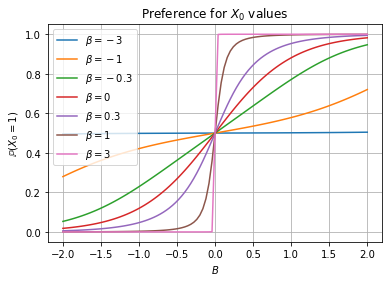

In [233]:
Bs = np.linspace(-2, 2, 101)
betas = [-3, -1, -0.3, 0, 0.3, 1, 3]

for beta in betas:
    probabilities = []
    for B in Bs:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    plt.plot(Bs, probabilities, label=f'$\\beta={beta}$')
plt.title('Preference for $X_0$ values')
plt.xlabel('$B$')
plt.ylabel('$\mathbb{P}(X_0=1)$')
plt.grid(True)
plt.legend()
plt.savefig('../img/ising_x0_B.png')

### P(X1, X2)

In [178]:
mu = optimize(beta=0, B=0, kappa=2, ftol=1e-10)

mu_edge = np.sum(mu, axis=0)
leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                      [mu_edge[1] / 2, mu_edge[0]],])
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

leaf_dist=array([[5.00000000e-01, 2.67667832e-14],
       [2.67667832e-14, 5.00000000e-01]])
p_x1=array([0.5, 0.5]) p_x2=array([0.5, 0.5])
np.outer(p_x1, p_x2)=array([[0.25, 0.25],
       [0.25, 0.25]])


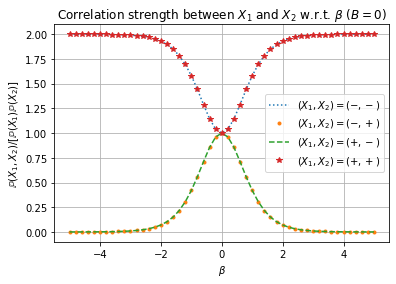

In [228]:
betas = np.linspace(-5, 5, 51)
probabilities = []

for beta in betas:
    mu = optimize(beta=beta, B=0, kappa=2, ftol=1e-10)

    mu_edge = np.sum(mu, axis=0)
    leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                        [mu_edge[1] / 2, mu_edge[0]],])
    p_x1 = np.sum(leaf_dist, axis=1)
    p_x2 = np.sum(leaf_dist, axis=0)
    indep_dist = np.outer(p_x1, p_x2)
    probabilities.append(leaf_dist / indep_dist)
    
probabilities = np.array(probabilities)

plt.plot(betas, probabilities[:, 0, 0], ':', label='$(X_1, X_2)=(-, -)$')
plt.plot(betas, probabilities[:, 0, 1], '.', label='$(X_1, X_2)=(-, +)$')
plt.plot(betas, probabilities[:, 1, 0], '--', label='$(X_1, X_2)=(+, -)$')
plt.plot(betas, probabilities[:, 1, 1], '*', label='$(X_1, X_2)=(+, +)$')
plt.legend()
plt.title('Correlation strength between $X_1$ and $X_2$ w.r.t. $\\beta$ ($B=0$)')
plt.xlabel('$\\beta$')
plt.ylabel('$\\mathbb{P}(X_1, X_2) / [\\mathbb{P}(X_1)\\mathbb{P}(X_2)]$')
plt.grid(True)
plt.savefig('../img/ising_x1_x2.png')

[[ 1. -1.]
 [-1.  1.]]


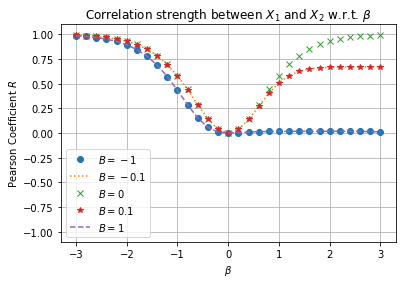

In [227]:
betas = np.linspace(-3, 3, 31)
pearson_coeff = []
Bs = [-1, -0.1, 0, .1, 1]

x_times_y = np.fromfunction(lambda x, y: (2*x-1) * (2*y-1), (2, 2))
xs = np.fromfunction(lambda x, y: 2*x-1, (2, 2))
ys = np.fromfunction(lambda x, y: 2*y-1, (2, 2))
print(x_times_y)

for B, m in zip(Bs, ['o', ':', 'x', '*', '--']):
    pearson_coeff = []

    for beta in betas:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)

        mu_edge = np.sum(mu, axis=0)
        leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                            [mu_edge[1] / 2, mu_edge[0]],])
        p_x1 = np.sum(leaf_dist, axis=1)
        p_x2 = np.sum(leaf_dist, axis=0)
        indep_dist = np.outer(p_x1, p_x2)
        
        cov = np.sum(leaf_dist * x_times_y) - np.sum(leaf_dist * xs) * np.sum(leaf_dist * ys)
        var0 = np.sum(p_x1 * np.array([-1, 1])**2) - np.sum(p_x1 * np.array([-1, 1]))**2
        var1 = np.sum(p_x2 * np.array([-1, 1])**2) - np.sum(p_x2 * np.array([-1, 1]))**2
        pearson_coeff.append(cov / np.sqrt(var0 * var1))

    plt.plot(betas, pearson_coeff, m, label=f'${B=}$')

plt.legend()
plt.title('Correlation strength between $X_1$ and $X_2$ w.r.t. $\\beta$')
plt.xlabel('$\\beta$')
plt.ylabel('Pearson Coefficient $R$')
plt.grid(True)

plt.ylim((-1.1, 1.1))

plt.savefig('../img/ising_x1_x2_pearson.png')

### P(X1, X2 | X0)

In [241]:
mu = optimize(beta=1, B=1, kappa=2, ftol=1e-10)

x0 = 0
mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                      [mu_edge[1] / 2, mu_edge[0]],])
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}', f'{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

mu_edge=array([0.01821049, 0.23348783, 0.74830168])
leaf_dist=array([[0.74830168, 0.11674392],
       [0.11674392, 0.01821049]])
p_x1=array([0.86504559, 0.13495441]) p_x2=array([0.86504559, 0.13495441])
np.outer(p_x1, p_x2)=array([[0.74830388, 0.11674172],
       [0.11674172, 0.01821269]])


/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


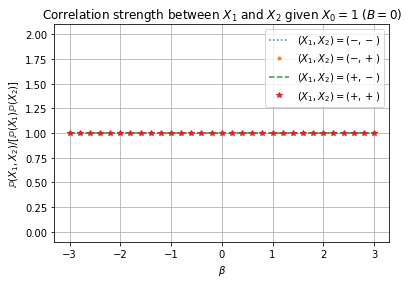

In [246]:
betas = np.linspace(-3, 3, 31)
probabilities = []

x0 = 1

for beta in betas:
    mu = optimize(beta=beta, B=0, kappa=2, ftol=1e-10)

    mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
    leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                        [mu_edge[1] / 2, mu_edge[0]],])
    p_x1 = np.sum(leaf_dist, axis=1)
    p_x2 = np.sum(leaf_dist, axis=0)
    indep_dist = np.outer(p_x1, p_x2)
    probabilities.append(leaf_dist / indep_dist)
    
probabilities = np.array(probabilities)

plt.plot(betas, probabilities[:, 0, 0], ':', label='$(X_1, X_2)=(-, -)$')
plt.plot(betas, probabilities[:, 0, 1], '.', label='$(X_1, X_2)=(-, +)$')
plt.plot(betas, probabilities[:, 1, 0], '--', label='$(X_1, X_2)=(+, -)$')
plt.plot(betas, probabilities[:, 1, 1], '*', label='$(X_1, X_2)=(+, +)$')
plt.legend()
plt.title(f'Correlation strength between $X_1$ and $X_2$ given $X_0={2*x0-1}$ ($B=0$)')
plt.xlabel('$\\beta$')
plt.ylabel('$\\mathbb{P}(X_1, X_2) / [\\mathbb{P}(X_1)\\mathbb{P}(X_2)]$')
plt.grid(True)
plt.ylim(-0.1, 2.1)
plt.savefig(f'../img/ising_x1_x2_x0={2*x0-1}.png')

[[ 1. -1.]
 [-1.  1.]]


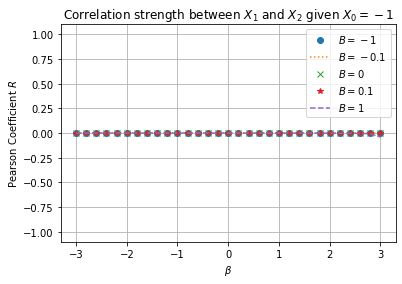

In [250]:
betas = np.linspace(-3, 3, 31)
pearson_coeff = []
Bs = [-1, -0.1, 0, .1, 1]

x0 = 0

x_times_y = np.fromfunction(lambda x, y: (2*x-1) * (2*y-1), (2, 2))
xs = np.fromfunction(lambda x, y: 2*x-1, (2, 2))
ys = np.fromfunction(lambda x, y: 2*y-1, (2, 2))
print(x_times_y)

for B, m in zip(Bs, ['o', ':', 'x', '*', '--']):
    pearson_coeff = []

    for beta in betas:
        mu = optimize(beta=beta, B=B, kappa=2, ftol=1e-10)

        mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
        leaf_dist = np.array([[mu_edge[2], mu_edge[1] / 2],
                            [mu_edge[1] / 2, mu_edge[0]],])
        p_x1 = np.sum(leaf_dist, axis=1)
        p_x2 = np.sum(leaf_dist, axis=0)
        indep_dist = np.outer(p_x1, p_x2)
        
        cov = np.sum(leaf_dist * x_times_y) - np.sum(leaf_dist * xs) * np.sum(leaf_dist * ys)
        var0 = np.sum(p_x1 * np.array([-1, 1])**2) - np.sum(p_x1 * np.array([-1, 1]))**2
        var1 = np.sum(p_x2 * np.array([-1, 1])**2) - np.sum(p_x2 * np.array([-1, 1]))**2
        pearson_coeff.append(cov / np.sqrt(var0 * var1))

    plt.plot(betas, pearson_coeff, m, label=f'${B=}$')

plt.legend()
plt.title(f'Correlation strength between $X_1$ and $X_2$ given $X_0={2*x0-1}$')
plt.xlabel('$\\beta$')
plt.ylabel('Pearson Coefficient $R$')
plt.grid(True)

plt.ylim((-1.1, 1.1))

plt.savefig(f'../img/ising_x1_x2_pearson_x0={2*x0-1}.png')

## Edge distribution and cavity field

In [18]:
kappa = 4
num_rep = 10
Bs = np.linspace(-1, 1, 11)
betas = np.linspace(-3, 3, 11)
reps = np.arange(num_rep)
betam, Bm, repm = np.meshgrid(betas, Bs, reps, indexing='ij')

mus = []
for beta, B in tqdm(zip(betam.flatten(), Bm.flatten()), total=len(betam.flatten())):
    mu = optimize(beta, B, kappa)
    mus.append(mu)
    
mus = np.array(mus).reshape(*betam.shape, 2, kappa+1)

100%|██████████| 1210/1210 [01:25<00:00, 14.12it/s]


beta=1.7999999999999998, B=0.0


/var/folders/wz/gr0d0g59325_bxkgsxrg4sxw0000gn/T/ipykernel_62545/172399762.py:11: RuntimeWarning: invalid value encountered in scalar divide
  h_neg.append(-(np.log(pi_mu[0, 0] / pi_mu[0, 1]) / 2 - beta))
/var/folders/wz/gr0d0g59325_bxkgsxrg4sxw0000gn/T/ipykernel_62545/172399762.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  h_pos.append(np.log(pi_mu[1, 1] / pi_mu[1, 0]) / 2 - beta)
/var/folders/wz/gr0d0g59325_bxkgsxrg4sxw0000gn/T/ipykernel_62545/172399762.py:10: RuntimeWarning: invalid value encountered in scalar divide
  h_pos.append(np.log(pi_mu[1, 1] / pi_mu[1, 0]) / 2 - beta)
/var/folders/wz/gr0d0g59325_bxkgsxrg4sxw0000gn/T/ipykernel_62545/172399762.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  h_neg.append(-(np.log(pi_mu[0, 0] / pi_mu[0, 1]) / 2 - beta))
/var/folders/wz/gr0d0g59325_bxkgsxrg4sxw0000gn/T/ipykernel_62545/172399762.py:10: RuntimeWarning: divide by zero encountered in log
  h_pos.append(np.log(pi_mu[1, 1] / pi_mu[1, 0]) / 2

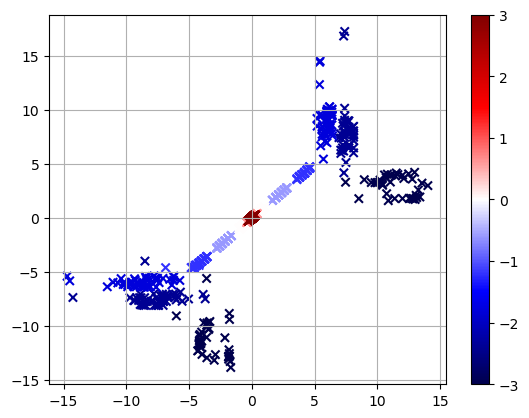

In [36]:
beta_index, B_index = 8, 5
beta, B = betam[beta_index, B_index, 0], Bm[beta_index, B_index, 0]
print(f'{beta=}, {B=}')


h_pos = []
h_neg = []
for beta, mu in zip(reversed(betam.flatten()), reversed(mus.reshape(-1, 2, kappa+1))):
    pi_mu = edge_distribution(mu, kappa)
    h_pos.append(np.log(pi_mu[1, 1] / pi_mu[1, 0]) / 2 - beta)
    h_neg.append(-(np.log(pi_mu[0, 0] / pi_mu[0, 1]) / 2 - beta))
    
    
h = np.linspace(min(*h_pos, *h_neg), min(*h_pos, *h_neg), 2)
plt.plot(h, h, color='gray')
img = plt.scatter(h_pos, h_neg, c=betam.flatten(), cmap='seismic', marker='x')
plt.colorbar(img)
plt.grid(True)